In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# The model
The model wants to simulate the movement of some birds sitting on a telephone wire.\
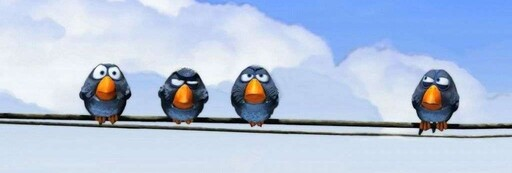\
Let us consider an initial configuration of the model.

In [2]:
def plot_birds(position): # position includes the two endpoints
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot([0, 1], [0, 0], color='black', linewidth=2)
    ax.scatter(position[1:N+1], [0]*(N), color='dodgerblue', s=100, zorder = 2)
    ax.scatter([0.0025, 1], [0, 0], color='red', marker="|", s=3000)
    ax.set_xlim(0, 1)
    ax.set_title('Telephone line')
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return fig

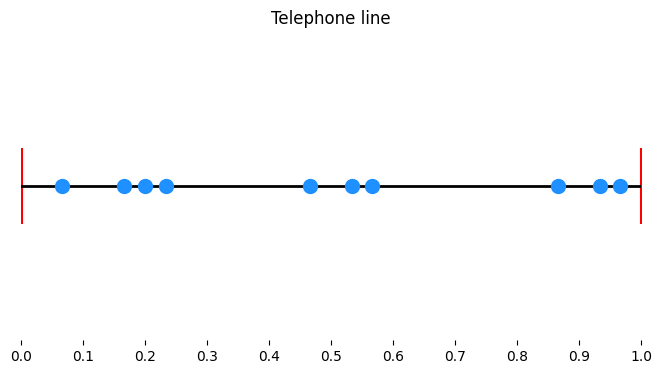

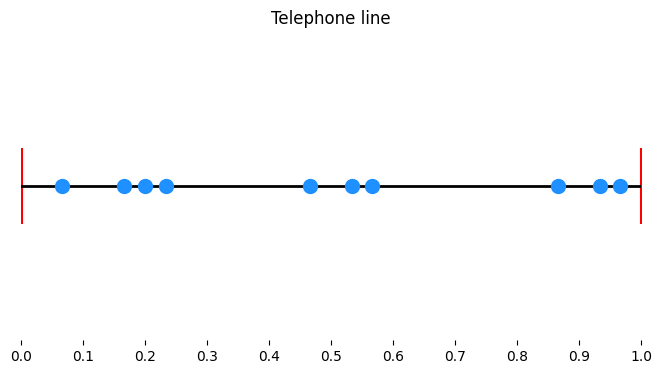

In [3]:
N = 10 # number of birds
L = 30 # points on the wire
initial_position = np.sort(np.random.choice(L - 1, N, replace=False) + 1) / L # Uniform distribution as initial point
position = np.insert(initial_position, [0, N], [0, 1])

plot_birds(position)

At the beginning there are $N$ birds distributed on the wire $[0, 1]$. Each bird will feel uncomfortable because of the other birds on the wire and will consequently try to adjust his position on the $L$ points of the wire, that is $\mathcal{X}_L:=\{\frac{1}{L}, \frac{2}{L},\cdots, \frac{L-1}{L}\}$, to make themselves more comfortable. We hence define the _Uncomfortability Function_ as a function $\varphi_L:\mathcal{X}_L\to\mathbb{R}^+$ that takes as argument the distance between two birds. Such function $\varphi_L$ will naturally be decreasing: the closer 2 birds are to each others, the more uncomfortable they will feel.\
We now want to ensure 3 conditions:
* The birds should always avoid collisions, if there is no possibility of collision the birds should be allowed to move in both directions.
* For each bird, total uncomfortability (penalty) should only depend on the distance from other birds.
* For each bird we need to calculate the _left uncomfortability_ and the _right uncomfortability_ to understand in which direction each bird is more willing to move.

We use $x = (x^1, \cdots, x^n, \cdots, x^N)$, which takes values in $E_L:=\{x: x^1<x^2< \cdots <x^N, x^n\in \mathcal{X}_L, 1\leq n\leq N\}$, to define the positions of the $N$ birds.

For each bird $n$ we can define the _left total uncomfortability penalty function_ as the sum of all the penalty with the birds on the left of $n$.
$$\phi_L^{n, left} := \sum_{k=0}^{n-1}\varphi_L (x^n - x^k)$$ 
and similarly 
$$\phi_L^{n, right} := \sum_{k=n+1}^{N+1}\varphi_L (x^k - x^n).$$

For each bird we now simulate 2 exponential random variables, one for the left penalty and one for the right penalty; the parameters will depend on the value of $\phi_L^{n, left}$ and $\phi_L^{n, right}$. The more a bird feels uncomfortable towards a certain direction the smaller the parameter $\lambda$ will be.

$$\dfrac{1}{\lambda_L^{n,left}(x)}:=\dfrac{1}{L}\cdot\dfrac{\Phi^{n,left}_L(x)}{|\Phi^{n,left}_L(x)-\Phi^{n,right}_L(x)|}+\eta_L(x^n,x^{n-1})$$

$$\dfrac{1}{\lambda_L^{n,right}(x)}:=\dfrac{1}{L}\cdot\dfrac{\Phi^{n,right}_L(x)}{|\Phi^{n,left}_L(x)-\Phi^{n,right}_L(x)|}+\eta_L(x^{n+1},x^{n})$$

The function $\eta_L(x,y) :=\infty \cdot \mathbb{1}_{x-y=\frac{1}{L}}$ is used to avoid collision between birds.

In [4]:
def penalty_function(x, L):
    N = len(x)
    position = x[:, np.newaxis]
    distances = abs(position - position.T) # Matrix of distances
    dis_negative = np.tril(distances) # Left distances matrix
    dis_positive = np.triu(distances) # Right distances matrix
    dis_negative = np.delete(dis_negative, [0, -1], axis=0) 
    dis_positive = np.delete(dis_positive, [0, -1], axis=0)

    dis = np.vstack((dis_negative, dis_positive))

    # penalty = 2 * np.power(1/2, dis)

    penalty = 1 / dis

    penalty[dis == 0] = 0
    pen = np.sum(penalty, axis=1) 
    pen_neg = pen[0:N-2]
    pen_pos = pen[N-2:]

    tot_penalty = pen / abs(np.hstack((pen_neg - pen_pos, pen_neg - pen_pos))) + 10E-14
    dis_is_1_vector = np.any(dis == 1/L, axis=1) 
    tot_penalty[dis_is_1_vector] += 10E7
    return tot_penalty

Now we decide which bird will move first and after how long it will move using the following method.

We simulate the $2N$ exponential random variables (recall that each bird has a r.v. related to the possibility to move in each directions), and keep the smallest one. We will then move the bird that decided to move as first towards the related direction. After the first jump, since the state has changed, each bird will need to think again about where to move. For this reason, for the second jump, we simulate once again $2N$ new exponential random variable and proceed using the same method. 

In [5]:
def model(initial_position, L): # simulates one jump
    N = len(initial_position) - 2
    tot_pen = penalty_function(initial_position, L)

    cum_sum_lambdas = np.cumsum(1/tot_pen)
    sum_lambdas = cum_sum_lambdas[-1]
    uniform_var = np.random.uniform(0, sum_lambdas)
    index = np.argmax(cum_sum_lambdas > uniform_var)
    
    time = np.random.exponential(1 / sum_lambdas)

    direction = ((index >= N ) * 2 - 1) / L
    direction_vector = np.zeros(N)
    direction_vector[index % N] = direction
    direction_vector = np.insert(direction_vector, [0, N], [0, 0])

    final_position = initial_position + direction_vector
    
    return final_position, time

def update(frame): # update function for the animation
    global final_position, time_vector, tot_time
    final_position, time = model(final_position, L)

    tot_time += time/L
    time_approx = np.round(time/L, 5)

    title = "Time for last jump: " + str(time_approx) + "\n Total time: " + str(np.round(tot_time, 5))
    ax.set_title(title)
    time_vector[frame] = time

    scatter.set_offsets(np.column_stack((final_position[1:N+1], [0]*(N))))
    return scatter,

### Let us show the animation of $10$ birds moving according to the model.

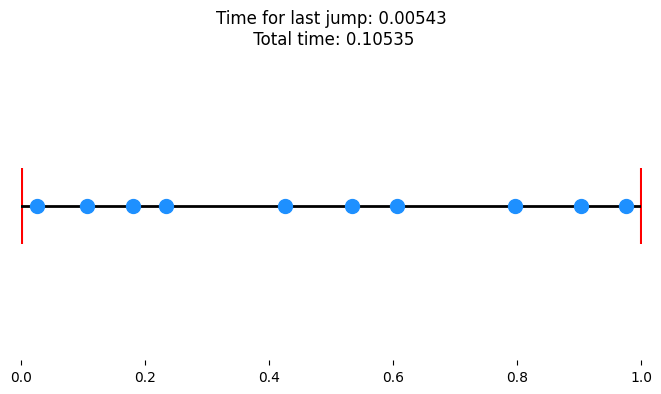

In [7]:
N = 10
L = 100
iter = 100


tot_time = 0
time_vector = np.zeros(iter)

# Setting initial position
final_position = np.sort(np.random.choice(L - 1, N, replace=False) + 1) / L # Uniform distribution
final_position = np.insert(final_position, [0, N], [0, 1]) # Adding the edges
final_position = position
# Plot
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot([0, 1], [0, 0], color='black', linewidth=2)
scatter = ax.scatter(final_position[1:N+1], [0]*(N), color='dodgerblue', s=100, zorder = 2)
ax.scatter([0.001, 1], [0, 0], color='red', marker="|", s=3000)
ax.set_xlim(0, 1)
ax.set_title('Telephone line')
ax.set_yticks([])  # Remove y-axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

anim = FuncAnimation(fig, update, frames=iter, interval=400, blit=True, repeat=False)
HTML(anim.to_jshtml())
# anim.save('video3.gif', writer='ffmpeg') # to save the animation as a gif

We can now notice that the random variable constructed by taking the minimum of the $2N$ independent exponential random variables is an exponential random variable. This means that we constructed a jump process where the increments follow an exponential random variable, hence, since we are using the same definition of jump process given in class, what we have is a Markov Jump Process.

From now on we will fix $N = 10$, we are not interested in what happens when the number of birds changes but we are interested in what happens when the time $t \rightarrow \infty$ and when the line becomes more and more _"continuous"_ ($L \rightarrow \infty$).

## Ergodic behavior
As time goes on the birds will continue to move, each bird trying to reach a more and more comfortable position. We now want to study what happens as $t \rightarrow \infty$.\
Let us recall the following result for Markov jump processes. \
If $E$ is a finite space and $(X_t)_t\ge0$ is a Markov jump process defined on it, we consider the case where one point of $E$ is accessible from any other point:
$$ \text{~(DC)~~~~} \exists x_0 \in E \text{~and~} t_0>0 \text{~such that~} \forall x \in E, \mathbb{P}\left(X_{t_0}=x_0 \mid X_0=x\right)>0.$$
When Doeblin's condition $(DC)$ is satisfied, we can find a unique $\mu_S \in \mathcal{P} (E)$, and two constants $C, \lambda>0$ such that for any $t \geq 0$ and any initial condition $X_0$,
$$\sum_{i \in E}\left|\mathbb{P}\left(X_t=i\right)-\left(\mu_S\right)_i\right| \leq C e^{-\lambda t}$$
Hence we are only left to prove Doeblin's condition for the _Bird-on-Wire_ process.

The proof we managed to create is quite laborious, for this reason we are not going to report it here but can be found in the attached paper under _Theorem 3.1_.

Now that we know that as $t \rightarrow \infty$ the distribution of the process will converge to a _Final distribution_ $\mu_S$ , we want to understand how this distribution looks like, especially when L is large enough.

We start by considering the time asymptotic behavior of the process. By its construction, as time increases, birds will try to make the left uncomfortability penalty and the right one equal to each other. We can easily notice this in the following simulation. 

We still consider $10$ birds but this time we take the number of points on the wire $L$ large enough, and we reproduce $t \rightarrow \infty$ by simulating a large number of jumps (_`iter`_).

Iteration 10000 (10.0%)
Iteration 20000 (20.0%)
Iteration 30000 (30.0%)
Iteration 40000 (40.0%)
Iteration 50000 (50.0%)
Iteration 60000 (60.0%)
Iteration 70000 (70.0%)
Iteration 80000 (80.0%)
Iteration 90000 (90.0%)
Iteration 100000 (100.0%)


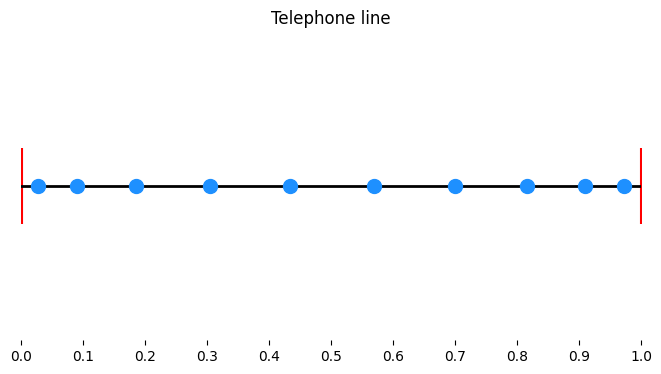

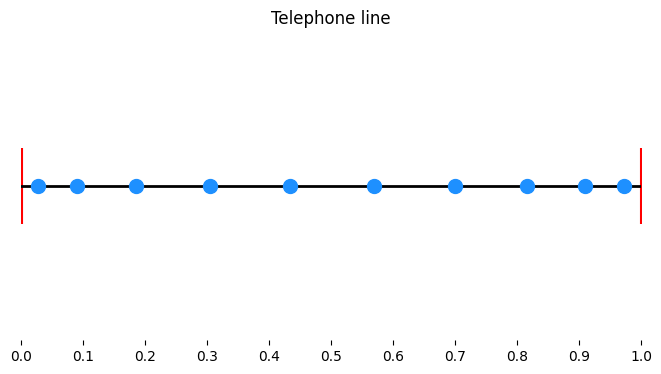

In [8]:
N = 10 
L = 10000
iter = 100000 # number of iterations

final_position = np.sort(np.random.choice(L - 1, N, replace=False) + 1) / L # Uniform distribution
final_position = np.insert(final_position, [0, N], [0, 1]) # Adding the edges

for i in range(iter): # Run the model to see what the position looks like when t tends to infinity
    if i % 10000 == 10000 - 1: print(f"Iteration {i + 1} ({(i + 1) / iter * 100:.1f}%)")
    final_position, time = model(final_position, L)

plot_birds(final_position)

It appears, as expected, that the process eventually reaches a state that seems "stable", where each bird has nearly attained a position where the discomfort penalty on the left is roughly equivalent to that on the right. 

Now let us compare such a state with the real stable state as defined in _Definition 3.1_. By _Lemma 3.1_, we know the true stable state indeed exists in the continuous case. Like what we did in the proof of _Lemma 3.1_ we find such a point by optimizing a pseudo-potential, using a machine learning algorithm.

<!-- Before delving further, it's prudent to consider what the exact stable state would entail and whether it closely aligns with the final state obtained from the aforementioned simulation. -->
<!-- 
In the discrete case we usually cannot find a stable point. If we use the same uncomfortability function when $L$ increases


By $Lemma 3.1$ from the attached paper, we can prove that when $L \rightarrow \infty$, which is when the interval $[0, 1]$ becomes continuous, it exists a unique stable points. We believe that the stable point found when $L \rightarrow \infty$ (in the continuous case) will be close to the stable point in the discrete case. We compute the stable point in continuous space using the library _SciPy_ -->

In [9]:
def pseudo_potential(x):
    N = len(x)
    x = np.insert(x, [0, N], [0, 1])
    position = x[:, np.newaxis]
    distances = abs(position - position.T)

    dis_positive = np.triu(distances)
    dis_negative = np.tril(distances)
    dis_positive = np.delete(dis_positive, [0, -1], axis=0)
    dis_positive = np.delete(dis_positive, [0, 1], axis=1)
    dis_negative = np.delete(dis_negative, [0, -1], axis=0)
    dis_negative = np.delete(dis_negative, [-2, -1], axis=1)
 
    # penalty_neg = 2 * np.power(1/2, d_neg)
    # penalty_pos = 2 * np.power(1/2, d_pos)

    penalty_neg = 1 / dis_negative
    penalty_pos = 1 / dis_positive
    pen_neg = np.sum(np.tril(penalty_neg), axis=1)
    pen_pos = np.sum(np.triu(penalty_pos), axis = 1)
    pen_error = abs(pen_neg - pen_pos)
    tot_pen = np.sum(pen_error)
    return tot_pen

Continuos stable point:
 [0.         0.02755034 0.09036027 0.1835618  0.30023428 0.43172335
 0.56827628 0.69976534 0.81643799 0.90963961 0.97244961 1.        ]


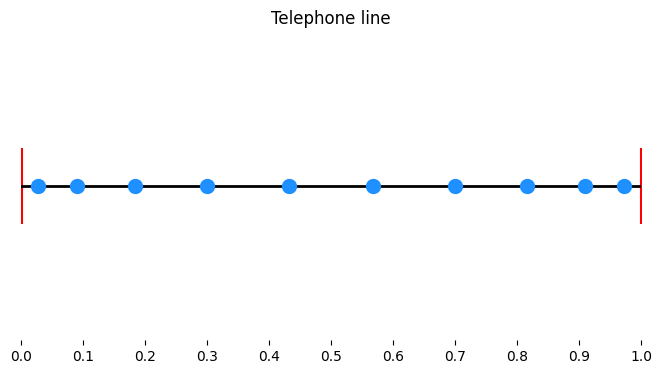

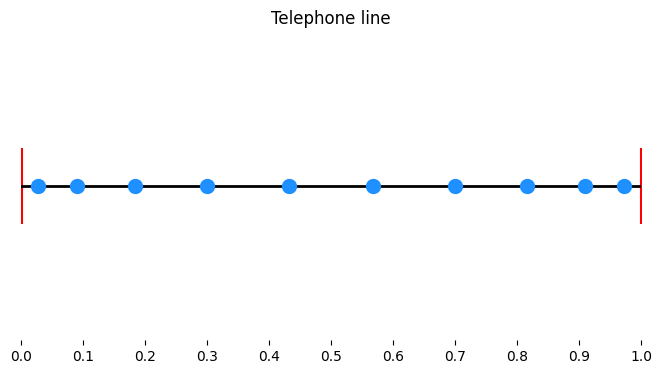

In [13]:
from scipy.optimize import minimize

x_initial = np.sort(np.random.rand(N))

bounds = [(0, 1.0)] * len(x_initial)  # define the bounds for each component of the vector
N = len(x_initial)
result = minimize(pseudo_potential, x_initial, bounds=bounds, options={'maxiter': 1000}, tol=1e-20, method='SLSQP') # we find the configuration that minimizes the potential
minimum = result.fun
stable_point = np.sort(result.x)
stable_point = np.insert(stable_point, [0, N], [0, 1])

print("Continuos stable point:\n", np.sort(stable_point))
plot_birds(stable_point)

Let us compare such solution with the solution found simulating the process when the space was discrete.

In [14]:
L1_norm = np.linalg.norm(stable_point[1:-1] - final_position[1: -1], ord=1)
print("Average distance between birds in the 2 different cases:", L1_norm / (len(stable_point) - 2))

Average distance between birds in the 2 different cases: 0.0011621687064117495


We notice that, as expected, the stable point in the discrete case is very close to the stable point in the continuous case, but they are not exactly equal to each other. This makes sense since, due to the discrete nature of the state space, it is very unlikely that the state space can precisely accommodate a state where the discomfort penalty for each bird exactly matches on both sides. We defined such state as _stable state_ in _Definition 3.1_. Consequently, the _"final distribution"_ of the process cannot be a point distribution, as per _Lemma 3.2_, which makes the problem difficult to approach.

As the number of points $L$ increases, the discrete state space $E_L$ will be closer to the continuous one $E:=\{x^1<x^2<\cdots<x^N: x^n\in (0,1), 1\leq n\leq N\}$. Correspondingly, the _"final distribution"_ should be more and more centrally distributed at the stable state as $L$ tends to infinity. In another word, the idea is to prove numerically that, 
there exists a point $\bar x$ (in fact the stable point) in $E$ such that given $L$ large enough, we have the following inequality:
$$ \mathbb{P}\left(\|X^L_t-\bar x\|_{l_1} \leq \omega(1/L)\right) \geq  0.95, \text{~as~} t\to \infty. $$
where $\omega$ is a modulus of continuity related to $\phi$ and $N$. 

To numerically prove the guess (_Guess 3.1_), we need to simulate many times our process as $t \rightarrow \infty$, for different values of $L$. 
But this is a task that requires a large computational time. That is because, when we take the initial state following a uniform distribution, the processes take a large number of iterations before converging, especially for $L$ large. 

To simplify significantly the computation we would like to start our process not from a random uniform distribution but from a state that is close to the stable point. To be able to do this we first need to prove that the stopping time $T$ defined as: 
$$ T_L := inf_{t \ge 0}\{ X^L_t = \bar x_L\} $$
is finite almost surely, where $\bar x_L$ is chosen in $E_L$ such that it's sufficiently close to the stable point in the continuos case. The proof is on the attached paper, in _Lemma 3.2_.

By the Strong Markov property for Markov Jump Process, and the fact that $T_L$ is finite _a.s._, we can now start the process from $\bar x_L$.

In [15]:
def best_approximation(vector, L): # function that returns the closest state in E_L to the continuos stable point
    N = len(vector) - 2
    linspace_values = np.linspace(0, 1, L)
    closest_number = np.zeros(N)
    for i in range(N):
        closest_number[i] = min(linspace_values, key=lambda x: abs(vector[i+1] - x))
    return closest_number 

To find the value of the modulus of continuity $\omega$ we did some statistical analysis. Since
$$ \lim_{M \to \infty} \frac{1}{M}\sum_{i=1}^M \left( \mathbf{1_{\|X^{i,L}_t-\bar x\|_{l_1}  \leq \omega(1/L)}}\right) = \mathbb{P}\left(\|X^L_t-\bar x\|_{l_1} \leq \omega(1/L)\right),~~~ \forall t \geq 0$$
We simulated the process with $L \in \{200, 400, \cdots, 2400 \}$, using $M = 500$ and the number of jumps to be equal to $\frac{15}{N} \cdot L$. The number of jumps has to increase linearly as $L$ increases. This is because we defined the parameter $\lambda$ of the jump to be proportional to $L$ in order to maintain the magnitude of the speed constant when the number of points on the wire changes.

C:\Users\ryayi\AppData\Local\Temp\ipykernel_12604\3586382830.py:7: RuntimeWarning: divide by zero encountered in divide
  penalty_neg = 1 / d_neg
C:\Users\ryayi\AppData\Local\Temp\ipykernel_12604\3586382830.py:8: RuntimeWarning: divide by zero encountered in divide
  penalty_pos = 1 / d_pos


k = 20 (1/12)	20.0%
k = 20 (1/12)	40.0%
k = 20 (1/12)	60.0%
k = 20 (1/12)	80.0%
k = 20 (1/12)	100.0%


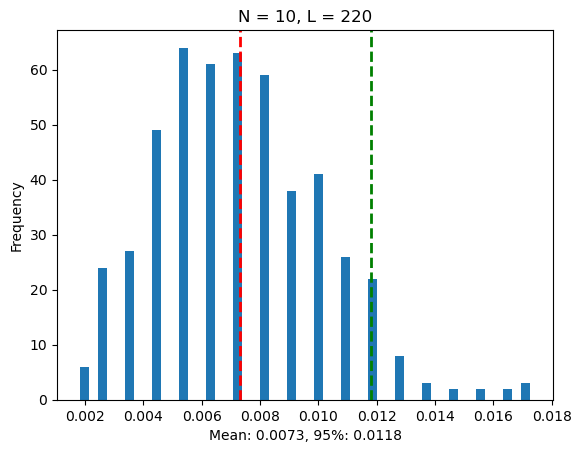

k = 40 (2/12)	20.0%
k = 40 (2/12)	40.0%
k = 40 (2/12)	60.0%
k = 40 (2/12)	80.0%
k = 40 (2/12)	100.0%


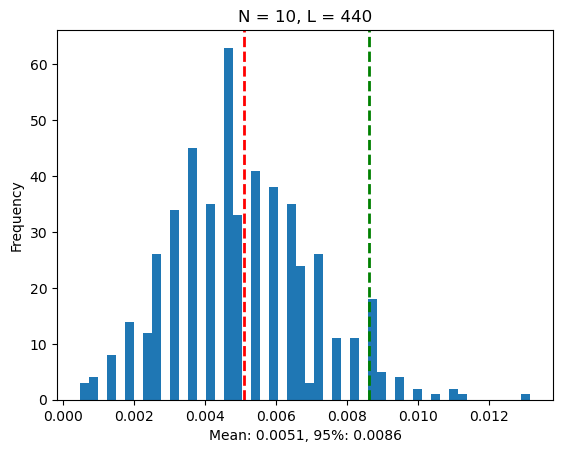

k = 60 (3/12)	20.0%
k = 60 (3/12)	40.0%
k = 60 (3/12)	60.0%
k = 60 (3/12)	80.0%
k = 60 (3/12)	100.0%


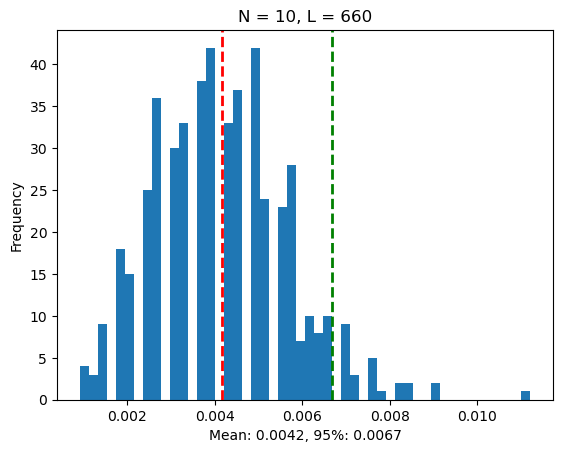

k = 80 (4/12)	20.0%
k = 80 (4/12)	40.0%
k = 80 (4/12)	60.0%
k = 80 (4/12)	80.0%
k = 80 (4/12)	100.0%


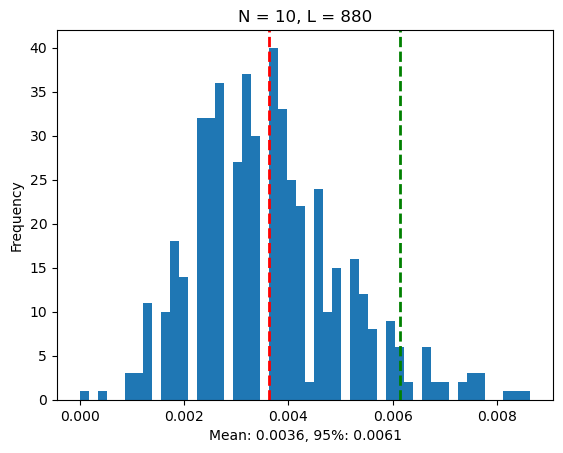

k = 100 (5/12)	20.0%
k = 100 (5/12)	40.0%
k = 100 (5/12)	60.0%
k = 100 (5/12)	80.0%
k = 100 (5/12)	100.0%


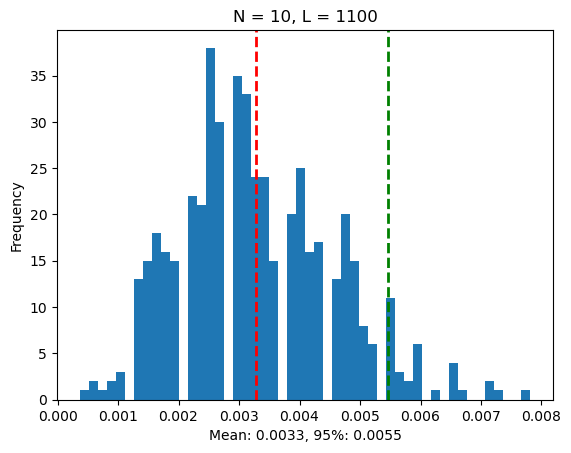

k = 120 (6/12)	20.0%
k = 120 (6/12)	40.0%
k = 120 (6/12)	60.0%
k = 120 (6/12)	80.0%
k = 120 (6/12)	100.0%


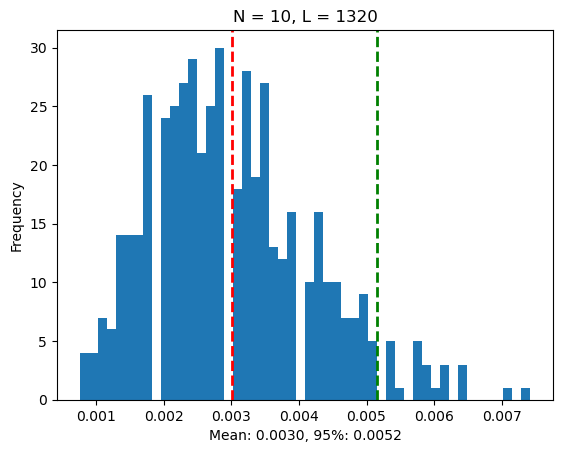

k = 140 (7/12)	20.0%
k = 140 (7/12)	40.0%
k = 140 (7/12)	60.0%
k = 140 (7/12)	80.0%
k = 140 (7/12)	100.0%


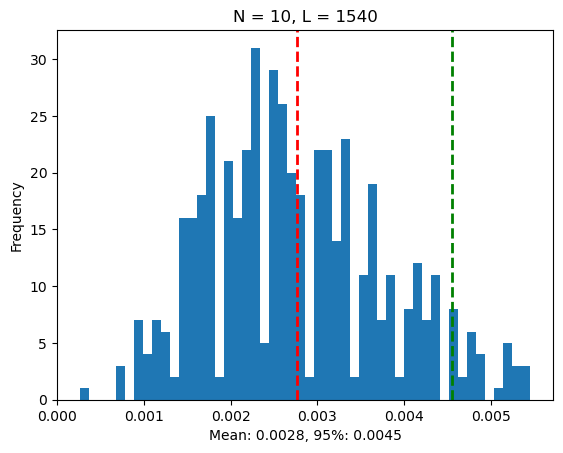

k = 160 (8/12)	20.0%
k = 160 (8/12)	40.0%
k = 160 (8/12)	60.0%
k = 160 (8/12)	80.0%
k = 160 (8/12)	100.0%


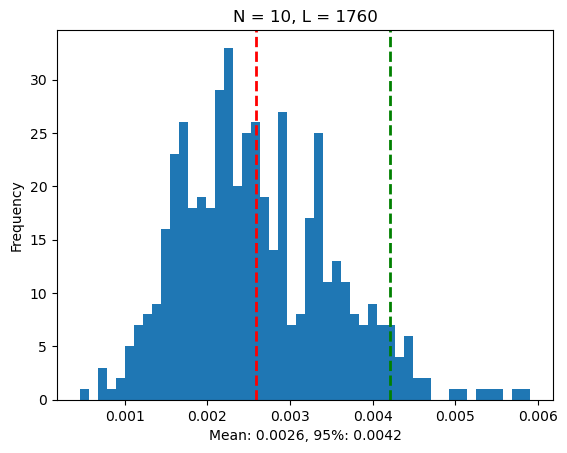

k = 180 (9/12)	20.0%
k = 180 (9/12)	40.0%
k = 180 (9/12)	60.0%
k = 180 (9/12)	80.0%
k = 180 (9/12)	100.0%


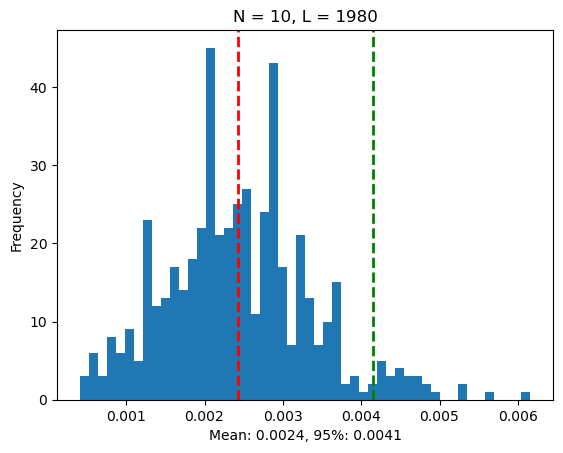

k = 200 (10/12)	20.0%
k = 200 (10/12)	40.0%
k = 200 (10/12)	60.0%
k = 200 (10/12)	80.0%
k = 200 (10/12)	100.0%


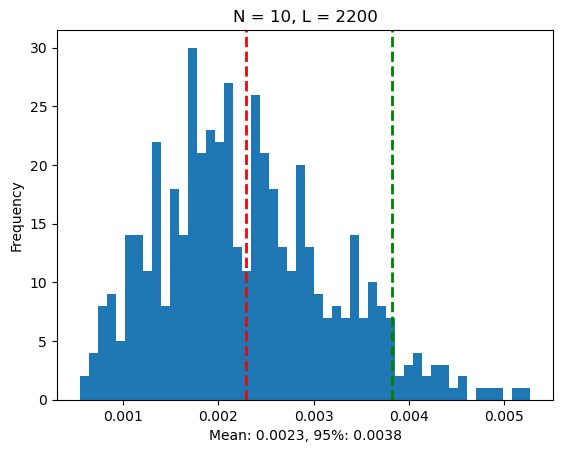

k = 220 (11/12)	20.0%
k = 220 (11/12)	40.0%
k = 220 (11/12)	60.0%
k = 220 (11/12)	80.0%
k = 220 (11/12)	100.0%


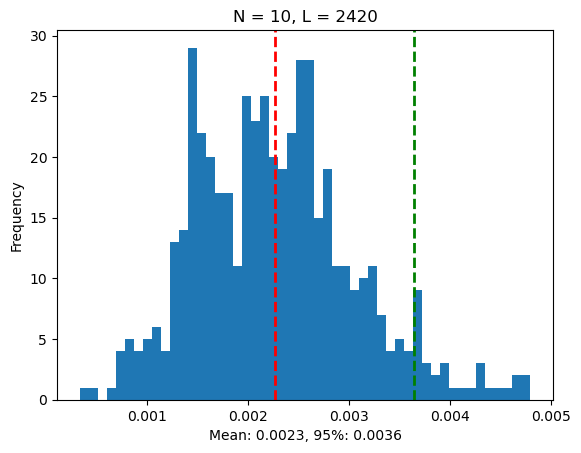

k = 240 (12/12)	20.0%
k = 240 (12/12)	40.0%
k = 240 (12/12)	60.0%
k = 240 (12/12)	80.0%
k = 240 (12/12)	100.0%


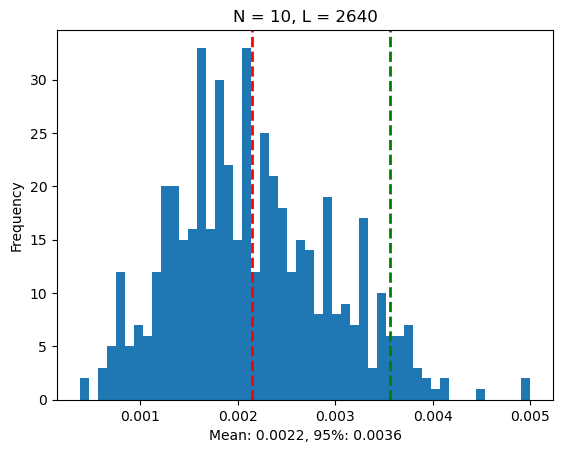

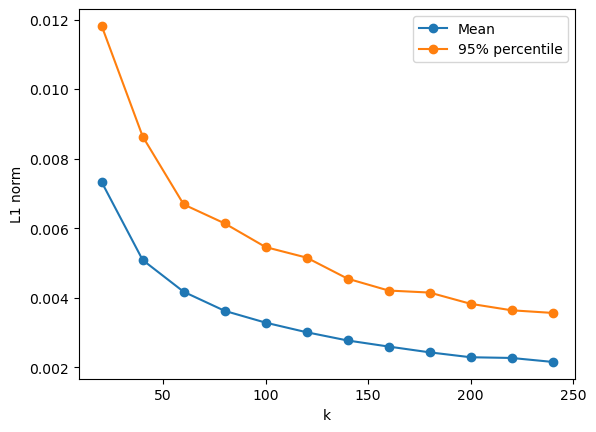

In [ ]:
kk = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
attempts = 500
N = 10
means = []
percentiles_95 = []
distributions = []
for k in kk:
    L = N * k
    iter = 15 * k 
    initial_position = best_approximation(stable_point, L)

    l1_norms = []

    for attempt in range(attempts):
        if (attempt%100 == 100 - 1): print(f"k = {k} ({kk.index(k) + 1}/{len(kk)})\t{(attempt+1)/attempts*100:.1f}%")
        final_position = initial_position
        final_position = np.insert(final_position, [0, N], [0, 1])

        for i in range(iter):  
            final_position = model(final_position, L)[0]
            
        l1_norm = np.linalg.norm(stable_point - final_position, ord=1)
        l1_norms.append(l1_norm / N)
    plt.hist(l1_norms, bins=50)
    distributions.append(l1_norms)
    
    mean = np.mean(l1_norms)
    means.append(mean)
    percentile = np.percentile(l1_norms, 95)
    percentiles_95.append(percentile)
    
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(percentile, color='g', linestyle='dashed', linewidth=2)
    plt.xlabel(f"Mean: {mean:.4f}, 95%: {percentile:.4f}")
    plt.ylabel("Frequency")

    plt.title(f"N = {N}, L = {L}")
    plt.show()

plt.plot(kk, means, '-o', label='Mean')
plt.plot(kk, percentiles_95, '-o', label='95% percentile')
plt.xlabel('k')
plt.ylabel('L1 norm')
plt.legend()

We can notice that the L1 norm of the difference between the continuos stable point $\bar x$ and the final state seems concentrating around zero as $L$ becomes larger. Now we try to numerically find the modulus of continuity $\omega$ of _Guess 3.1_.

After some attempts we guessed $\omega$ to be of the form $$\omega(r) = C \cdot r^{-\beta}.$$ We used linear regression to find the parameters $C$ and $\beta$ that best fit our guess.

[0.0073236363636363325, 0.005081818181818218, 0.004169090909090857, 0.0036204545454545053, 0.003280363636363558, 0.0030045454545453917, 0.0027675324675324963, 0.0025929545454546135, 0.002426464646464531, 0.002285454545454596, 0.0022649586776858927, 0.0021509090909090363]
[0.011818181818181775, 0.008636363636363683, 0.006681818181818145, 0.0061363636363635675, 0.005454545454545324, 0.005151515151515035, 0.004545454545454648, 0.004204545454545533, 0.0041464646464645614, 0.0038227272727274484, 0.0036363636363635444, 0.003560606060605972]
-0.4880941294443105 -1.799736124794613 0.00908808190181344


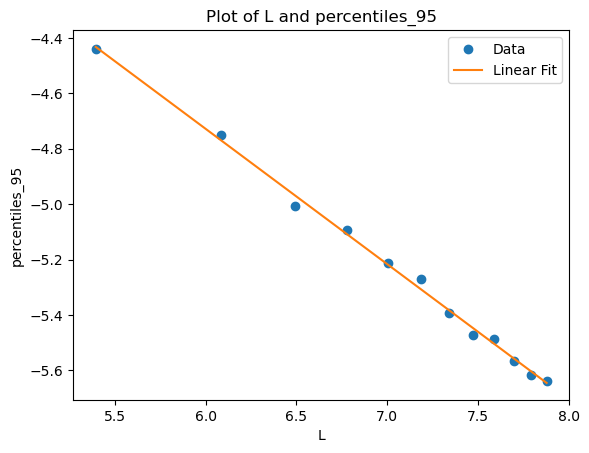

In [ ]:
from scipy.stats import linregress

np.savetxt('distributions.txt', distributions, delimiter='\t', fmt='%f')
print(means)
print(percentiles_95)

slope, intercept, r_value, p_value, std_err = linregress(np.log(np.array(kk) * 11), np.log(np.array(percentiles_95)))

L_log = np.log(np.array(kk) * 11)
per_log = slope * L_log + intercept
print(slope, intercept, std_err)

plt.plot(np.log(np.array(kk) * 11), np.log(np.array(percentiles_95)), 'o', label='Data')
plt.plot(L_log, per_log, label='Linear Fit')

plt.xlabel('L')
plt.ylabel('percentiles_95')
plt.title('Plot of L and percentiles_95')
plt.legend()
plt.show()

From the plot it suggests that $\omega$ is very close to the form we guessed. The _numerical_ final statement of _Guess 3.1_ should be as follows: $$ \mathbb{P}\left(\|X^L_t-\bar x\|_{l_1} \leq 0.165 \cdot L^{0.488}\right) \geq  0.95, \text{~as~} t\to \infty. $$